[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/stan/jet/notebooks/Normal_Crossing_SGLD_trajectory_notebook.ipynb)

# Normal Crossing SGLD trajectory notebook

This notebook uses SGLD to sample from the posterior around a point, for a polynomial model characterized by $y_{pred} = w_1^a * w_2^b * x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned and $x$ is our (1-dimensional) input.

Both the input $x$ and target data $y$ are generated using (independent) gaussian noise, and the loss is Mean Squared Error from $y$ to $y_{pred}$, so the model achieves its lowest loss when $w_1=0$ or $w_2=0$.


#Setup (skippable)

In [ ]:
# @title
%pip install devinterp pyro-ppl seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
# @title
import torch

In [ ]:
# @title
import os
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install devinterp pyro-ppl seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from pyro.infer import MCMC, NUTS
from torch.utils.data import DataLoader, TensorDataset

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import LLCEstimator, OnlineLLCEstimator, SamplerCallback
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, sample
from devinterp.utils import get_init_loss_multi_batch, plot_trace, default_nbeta
from devinterp.utils import evaluate_mse, evaluate
from functools import partial
evaluate_mae = partial(evaluate, F.l1_loss)
!pip install PyMoments
from PyMoments import kstat

# **Auxiliary functions**

In [ ]:
from copy import deepcopy


# @title
# some necessary functions
class PolyModel(nn.Module):
    def __init__(self, powers, device):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([0.0, 0.0], dtype=torch.float32, requires_grad=True).to(device)
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x * multiplied
        return x


class SumModel(nn.Module):
    def __init__(self, powers, device):
        super(SumModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([0.0, 0.0], dtype=torch.float32, requires_grad=True).to(device)
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.sum(self.weights**self.powers)
        x = x * multiplied
        return x


def generate_dataset_for_seed(seed, sigma, batch_size, num_samples):
    torch.manual_seed(seed)
    np.random.seed(seed)
    x = torch.normal(0, sigma, size=(num_samples,))
    y = torch.normal(0, sigma, size=(num_samples,))
    train_data = TensorDataset(x, y)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader, train_data, x, y


class WeightCallback(SamplerCallback):
    def __init__(self, num_chains: int, num_draws: int, model, device="cpu"):
        self.num_chains = num_chains
        self.num_draws = num_draws
        self.ws = np.zeros(
            (num_chains, num_draws, len(model.weights)), dtype=np.float32
        )
        self.device = device

    def update(self, chain: int, draw: int, model):
        self.ws[chain, draw] = model.weights.cpu().detach()

    def get_results(self):
        return {
            "ws/trace": self.ws,
        }

    def __call__(self, chain: int, draw: int, model, **kwargs):
        self.update(chain, draw, model)


# plotting
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)


def plot_trajectories(weight_trajectories, names, device):
    fig, axes = plt.subplots(1, len(weight_trajectories), figsize=(6, 6))
    if len(weight_trajectories) == 1:
        axes = [axes]
    model_copy = deepcopy(model)
    range_size = 5
    w1_range = np.linspace(-range_size, range_size, 21)
    w2_range = np.linspace(-range_size, range_size, 21)
    w1_vals, w2_vals = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(w1_vals, dtype=float)

    for i in range(w1_vals.shape[0]):
        for j in range(w1_vals.shape[1]):
            w1 = w1_vals[i, j]
            w2 = w2_vals[i, j]
            model_copy.weights = nn.Parameter(
                torch.tensor([w1, w2], dtype=torch.float32).to(device)
            )
            Z[i, j] = (
                model_copy.to(device)(torch.tensor(1.0).to(device)).item() ** 2
            ) + 0.0001 * w1 * w2  # MSE, so square this

    custom_levels = np.linspace(Z.min(), Z.max() * 0.04, n_bins)

    for i, weight_trajectory in enumerate(weight_trajectories):
        # axes[i].contourf(
        #     w1_vals, w2_vals, Z, levels=custom_levels, cmap=contour_cmap, alpha=0.8
        # )
        draws_array = np.array(
            [
                weight
                for weight in weight_trajectory
                if w1_range[0] <= weight[0] <= w1_range[-1]
                and w2_range[0] <= weight[1] <= w2_range[-1]
            ]
        )
        sns.scatterplot(
            x=draws_array[:, 0],
            y=draws_array[:, 1],
            marker="x",
            ax=axes[i],
            s=10,
            color=PRIMARY,
        )
        axes[i].axhline(0, linestyle="--", color="gray")
        axes[i].axvline(0, linestyle="--", color="gray")
        axes[i].set_xlabel(r"$w_{1}$")
        axes[i].set_ylabel(r"$w_{2}$")
        axes[i].set_title(names[i])
        axes[i].grid(False)
    plt.show()


def plot_multi_trajectories(wt, i_range, diffs_range, legend):
    num_chains = len(wt)
    for n in diffs_range:
        for i in i_range:
            diffs = new_ith_place_nth_diff(wt, i, n)
            plot_trajectories(
                diffs,
                names=[legend + f"_{chain} n={n} i={i}" for chain in range(num_chains)],
                device=DEVICE,
            )

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
SEED = 0
SIGMA = 1
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mae

train_loader, train_data, x, y = generate_dataset_for_seed(
    seed=SEED, sigma=SIGMA, batch_size=BATCH_SIZE, num_samples=NUM_TRAIN_SAMPLES
)

## **Marginal and joint distributions of jets**

In [ ]:
def ith_place_first_diff(ary, i):
    return -np.subtract(ary[:, :-i, :], ary[:, i:, :])


test_array = np.array([[[0.0], [1.0], [3.0]]])
should_be = np.array([1.0, 2.0])
print(ith_place_first_diff(test_array, 1).reshape(-1) - should_be.reshape(-1))


# Marginal distribution of n-th jet coordinate
def new_ith_place_nth_diff(ary, i, n=1):
    n_th_diff = ary
    for _ in range(n):
        n_th_diff = ith_place_first_diff(n_th_diff, i)
    return n_th_diff


# Joint distribution of n-jets
def joint_ith_place_nth_diff(ary, i, n=1):
    tot_length = ary.shape[1]
    list_jet_coordinates = [ary[:, : tot_length - n * i, :]]
    m_th_diff = ary
    for m in range(n):
        m_th_diff = ith_place_first_diff(m_th_diff, i)
        list_jet_coordinates.append(m_th_diff[:, : tot_length - n * i, :])
    return np.concatenate(list_jet_coordinates, axis=2)


test_array = np.array([[[0.0], [1.0], [3.0], [4.0]]])

should_be = np.array([1.0, -1.0])
print(new_ith_place_nth_diff(test_array, 1, n=2).reshape(-1) - should_be.reshape(-1))

[0. 0.]
[0. 0.]


## **Statistics of marginal distributions of jet coordinates**

In [ ]:
def plot_second_order_stats(wt, n):
    num_chains = len(wt)
    num_draws = len(wt[0])
    all_stds_x_per_i = []
    all_stds_y_per_i = []
    cov_x_y_per_i = []
    i_values = np.arange(1, num_draws // n - 2, 1)
    for i in i_values:
        diffs = new_ith_place_nth_diff(wt, i, n)
        std_x_y = np.std(diffs, axis=1)[0]
        cov_x_y = kstat(diffs.reshape(-1, diffs.shape[-1]), (0, 1))
        all_stds_x_per_i.append(std_x_y[0])
        all_stds_y_per_i.append(std_x_y[1])
        cov_x_y_per_i.append(cov_x_y)

    fig, ax1 = plt.subplots()  # Create a figure and a primary axe
    # Plot data on the primary y-axis

    ax1.plot(i_values, all_stds_x_per_i, label="xx")
    ax1.plot(i_values, all_stds_y_per_i, label="yy")
    ax1.plot(i_values, cov_x_y_per_i, label="xy")

    # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # Plot data on the secondary y-axis
    # ax2.plot(i_values, all_mean_dists_per_n, label='dist', color='r') # should be secondary_y

    # Add legends for both axes
    ax1.legend(loc="upper left")
    # ax2.legend(loc='upper right')

    plt.show()


def plot_third_order_stats(wt, n):
    num_chains = len(wt)
    num_draws = len(wt[0])
    diff_third_cum_xxx_per_i = []
    diff_third_cum_yyy_per_i = []
    diff_third_cum_xxy_per_i = []
    diff_third_cum_xyy_per_i = []
    i_values = np.arange(1, num_draws_sgld - 3, 1)
    for i in i_values:
        diffs = new_ith_place_nth_diff(wt, i, n)
        diffs = diffs.reshape(-1, diffs.shape[-1])
        diff_third_cum_xxx_per_i.append(kstat(diffs, (0, 0, 0)))
        diff_third_cum_yyy_per_i.append(kstat(diffs, (1, 1, 1)))
        diff_third_cum_xxy_per_i.append(kstat(diffs, (0, 0, 1)))
        diff_third_cum_xyy_per_i.append(kstat(diffs, (0, 1, 1)))
    fig, ax1 = plt.subplots()  # Create a figure and a primary axes

    # Plot data on the primary y-axis
    ax1.plot(i_values, diff_third_cum_xxx_per_i, label="xxx")
    ax1.plot(i_values, diff_third_cum_yyy_per_i, label="yyy")
    ax1.plot(i_values, diff_third_cum_xxy_per_i, label="xxy")
    ax1.plot(i_values, diff_third_cum_xyy_per_i, label="xyy")
    # Add legend
    ax1.legend(loc="upper left")

    plt.show()

## **Visualizing jet distributions with vector fields**

In [ ]:
# Courtesy of ChatGPT
def compute_binned_averages(A, xmin, xmax, ymin, ymax, n):
    # Number of columns to average over
    m = A.shape[1] - 2

    # Initialize the output array B of shape (n, n, m) with zeros
    B = np.zeros((n, n, m))
    # Initialize a count array of shape (n, n) to keep track of the number of elements in each bin
    count = np.zeros((n, n))

    # Define bin width for x and y
    x_bin_width = (xmax - xmin) / n
    y_bin_width = (ymax - ymin) / n

    # Iterate over each element in A
    for k in range(A.shape[0]):
        x, y = A[k, 0], A[k, 1]
        values = A[k, 2:]  # Extract the values starting from the third column

        # Check which bin (i, j) the point (x, y) belongs to
        i = int((x - xmin) // x_bin_width)
        j = int((y - ymin) // y_bin_width)

        # Ensure the indices are within bounds
        if 0 <= i < n and 0 <= j < n:
            # Add the values to the corresponding bin (for each column l in A[k][2:])
            B[i, j, :] += values
            # Increment the count for that bin
            count[i, j] += 1

    # Compute the average for each bin and each column
    # Avoid division by zero by only averaging where count > 0
    for l in range(m):
        B[:, :, l] = np.divide(
            B[:, :, l], count, where=(count > 0), out=np.zeros_like(B[:, :, l])
        )

    return B


import numpy as np


def compute_binned_averages_multi_with_std(A, xmin, xmax, ymin, ymax, n):
    # Number of columns to average over
    m = A.shape[1] - 2

    # Initialize the output array B of shape (n, n, m) for averages
    B_avg = np.zeros((n, n, m))
    # Initialize the array to hold the sum of squares
    B_sum_squares = np.zeros((n, n, m))
    # Initialize a count array of shape (n, n) to keep track of the number of elements in each bin
    count = np.zeros((n, n))

    # Define bin width for x and y
    x_bin_width = (xmax - xmin) / n
    y_bin_width = (ymax - ymin) / n

    # Iterate over each element in A
    for k in range(A.shape[0]):
        x, y = A[k, 0], A[k, 1]
        values = A[k, 2:]  # Extract the values starting from the third column

        # Check which bin (i, j) the point (x, y) belongs to
        i = int((x - xmin) // x_bin_width)
        j = int((y - ymin) // y_bin_width)

        # Ensure the indices are within bounds
        if 0 <= i < n and 0 <= j < n:
            # Add the values to the corresponding bin (for each column l in A[k][2:])
            B_avg[i, j, :] += values
            B_sum_squares[i, j, :] += values**2
            # Increment the count for that bin
            count[i, j] += 1

    # Compute the average for each bin and each column
    # Avoid division by zero by only averaging where count > 0
    for l in range(m):
        B_avg[:, :, l] = np.divide(
            B_avg[:, :, l], count, where=(count > 0), out=np.zeros_like(B_avg[:, :, l])
        )

    # Now compute the standard deviation for each bin and each column
    B_std = np.zeros((n, n, m))
    for l in range(m):
        # Use the formula std_dev = sqrt((sum_squares / N) - (mean^2))
        B_std[:, :, l] = np.sqrt(
            np.divide(B_sum_squares[:, :, l], count, where=(count > 0))
            - B_avg[:, :, l] ** 2
        )

    return B_avg, B_std

In [ ]:
def plot_vector_field(A, xmin, xmax, ymin, ymax):
    n = A.shape[0]  # Assuming A is of shape (n, n, 2)

    # Create the grid points for the plot
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)

    # Create meshgrid for plotting
    X, Y = np.meshgrid(x, y)

    # Extract the vector components from A
    U = A[:, :, 0]  # x-component of the vector field
    V = A[:, :, 1]  # y-component of the vector field

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.quiver(X, Y, U, V)

    # Set labels and plot title
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D Vector Field")

    # Set limits for x and y axis
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.gca().set_aspect("equal", adjustable="box")  # Equal scaling for axes
    plt.show()


def plot_vector_field_with_colors(A, C, xmin, xmax, ymin, ymax, i, n, legend):
    num_bins = A.shape[0]

    # Create the grid points for the plot
    x = np.linspace(xmin, xmax, num_bins)
    y = np.linspace(ymin, ymax, num_bins)

    # Create meshgrid for plotting
    X, Y = np.meshgrid(x, y)

    # Extract the vector components from A
    U = A[:, :, 0]  # x-component of the vector field
    V = A[:, :, 1]  # y-component of the vector field

    # Flatten the grid and the vectors for plotting
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    U_flat = U.flatten()
    V_flat = V.flatten()

    # Extract the values from C and flatten for coloring
    color_values = C[:, :].flatten()

    # Create the plot
    plt.figure(figsize=(6, 6))

    # Use quiver to plot the vector field, with color based on the array C
    quiver = plt.quiver(X_flat, Y_flat, U_flat, V_flat, color_values, cmap="viridis")

    # Add a colorbar to represent the color values from C
    plt.colorbar(quiver, label="Colored by standard deviations")

    # Set labels and plot title
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(legend + f" n={n}, i={i}")

    # Set limits for x and y axis
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)


def plot_vector_field_jets(wt, i_range, diffs_range, num_bins, legend):
    num_chains = len(wt)
    xmin = np.min(wt[:, :, 0])
    xmax = np.max(wt[:, :, 0])
    ymin = np.min(wt[:, :, 1])
    ymax = np.max(wt[:, :, 1])
    for n in diffs_range:
        for i in i_range:
            diffs = np.concatenate(joint_ith_place_nth_diff(wt, i, n))
            vect_field, colors = compute_binned_averages_multi_with_std(
                diffs, xmin, xmax, ymin, ymax, num_bins
            )
            plot_vector_field_with_colors(
                vect_field, colors[:, :, 0], xmin, xmax, ymin, ymax, i, n, legend
            )

# **Model definition**

In [ ]:
INITIAL_PARAMETERS = [0.0, 0.0]
A_B = [
    6,
    6,
]  # MSE loss function and zero-mean gaussian, so this is effectively w_1**2 * w_2**4 as loss, NB

nbeta = default_nbeta(len(train_data))  # = n/log(n)
model = SumModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(
    DEVICE
)  # lol idk which one it should be
model.weights = nn.Parameter(
    torch.tensor(INITIAL_PARAMETERS, dtype=torch.float32, requires_grad=True).to(DEVICE)
)

# **SGLD trajectories sampling**


In [ ]:
# Number and length of chains
num_chains_sgld = 1
num_draws_sgld = 10_000

# SGLD parameters
epsilon_sgld = 0.005

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)
sgld_weights = WeightCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=model
)

online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgld,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgld = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(lr=epsilon_sgld, nbeta=nbeta, bounding_box_size=3.0),
    sampling_method=SGLD,
    num_chains=num_chains_sgld,  # independent sampling runs
    num_draws=num_draws_sgld,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgld_weights],
    seed=SEED,
)

Chain 0: 100%|██████████| 10000/10000 [01:44<00:00, 95.59it/s]


In [ ]:
wt_sgld = np.array(sgld_weights.get_results()["ws/trace"])

# numpy running mean of llc_chain (does not work yet with multiple chains)
llc_chain = online_llc_estimator.get_results()["llc/trace"]
# llc_chain = np.cumsum(llc_chain) / np.arange(1, len(llc_chain[0]) + 1)
print(np.nonzero(np.isnan(wt_sgld)))
print(epsilon_sgld * num_draws_sgld)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
50.0


# **SGLD plots**

## **Plotting SGLD trajectories and jet coordinates**

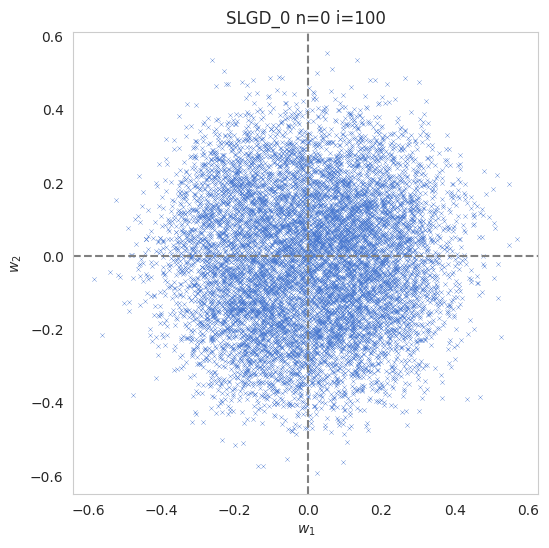

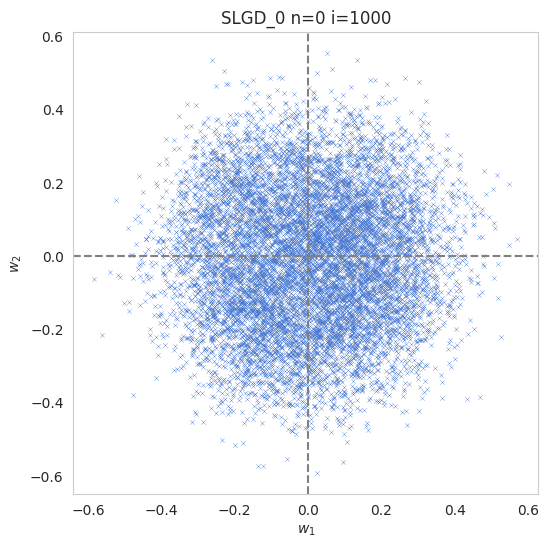

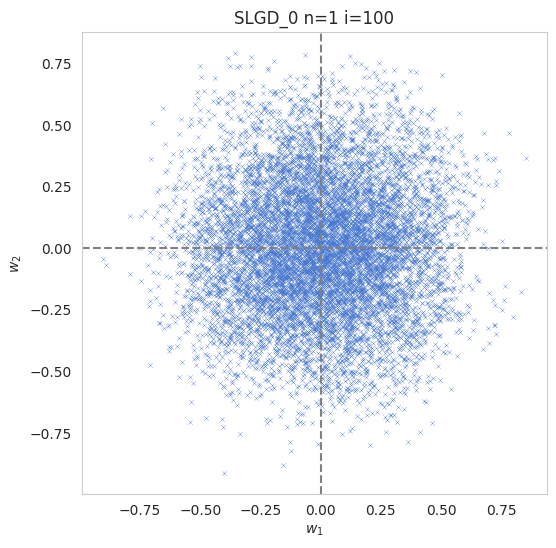

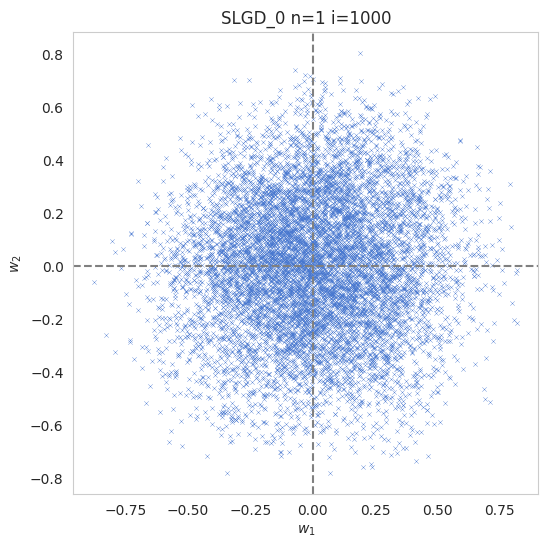

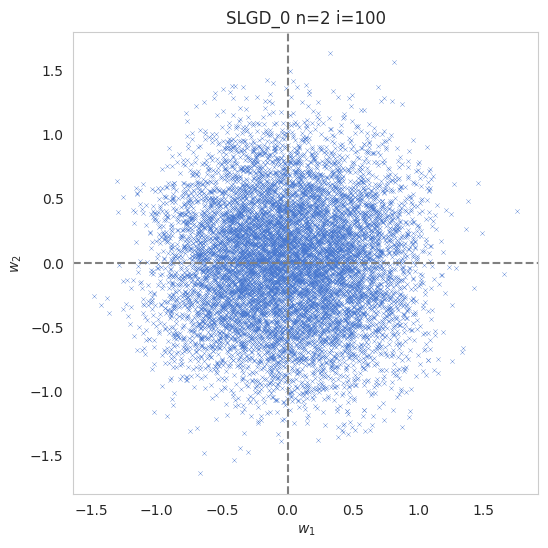

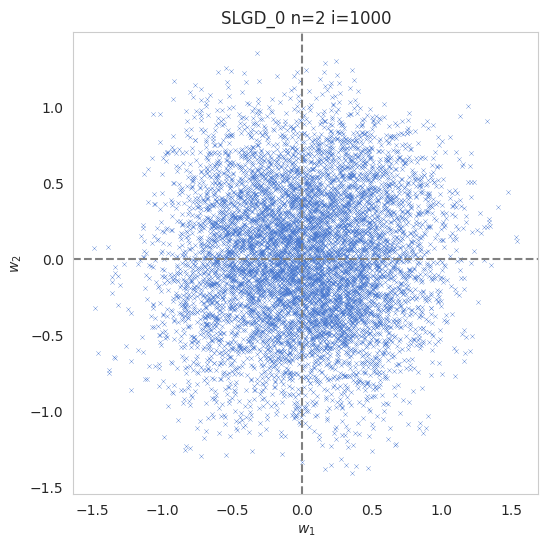

In [ ]:
plot_multi_trajectories(wt_sgld, [100, 1000], [0, 1, 2], "SLGD")

## **Plot cumulant statistics of marginal distribution of jet coordinates SGLD**


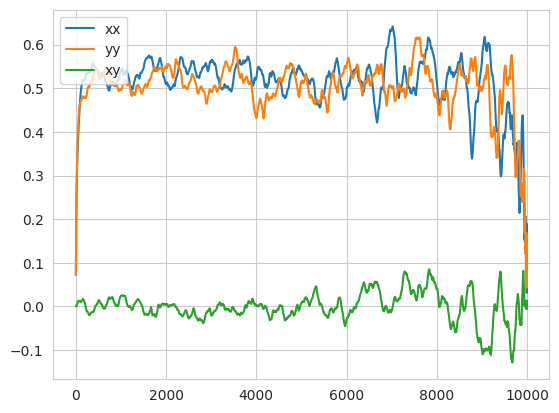

In [ ]:
plot_second_order_stats(wt_sgld, 1)

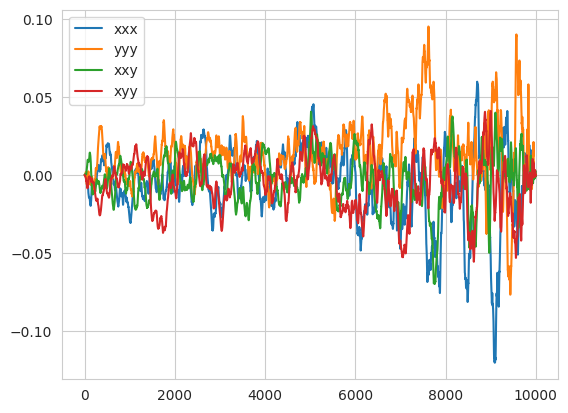

In [ ]:
plot_third_order_stats(wt_sgld, 1)

## **Vector fields SGLD**

In [ ]:
plot_vector_field_jets(wt_sgld, [10, 100, 500], [1], 15, "SGLD")

# **SGHNT trajectories sampling**

In [ ]:
num_chains_sgnht = 1
num_draws_sgnht = 10_000

epsilon_sgnht = 0.001

In [ ]:
sgnht_weights = WeightCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgnht,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=epsilon_sgnht, nbeta=nbeta, diffusion_factor=0.005, bounding_box_size=1.0
    ),
    sampling_method=SGNHT,
    num_chains=num_chains_sgnht,  # independent sampling runs
    num_draws=num_draws_sgnht,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgnht_weights],
    seed=SEED,
)

In [ ]:
wt_sgnht = np.array(sgnht_weights.get_results()["ws/trace"])

print(np.nonzero(np.isnan(wt_sgnht)))
print(epsilon_sgld * num_draws_sgnht)

# **SGNHT plots**

## **Plotting SGNHT trajectories and jet coordinates**




In [ ]:
plot_multi_trajectories(wt_sgnht, [1, 10], [0, 1, 2], "SGNHT")

## **Plot cumulant statistics of marginal distribution of jet coordinates SGNHT**

In [ ]:
plot_second_order_stats(wt_sgnht, 1)

In [ ]:
plot_third_order_stats(wt_sgnht, 1)

## **Vector fields SGNHT**

In [ ]:
plot_vector_field_jets(wt_sgnht, [10, 100, 500], [1], 15, "SGNHT")